<a href="https://colab.research.google.com/github/ambideXtrous9/Image-Classification-on-CIFAR100/blob/main/CIFAR_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
# import the necessary packages
from keras import Sequential
from keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2,InceptionV3,VGG16
from tensorflow.keras.layers import AveragePooling2D,Conv2D,Activation
from tensorflow.keras.layers import Dropout,BatchNormalization,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2
import tarfile
import pandas as pd
from google.colab.patches import cv2_imshow
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

label_mode: one of "fine", "coarse". If it is "fine" the category labels are the fine-grained labels, if it is "coarse" the output labels are the coarse-grained superclasses.
This is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 100 fine-grained classes that are grouped into 20 coarse-grained classes

In [2]:
_URL = 'https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'

In [3]:
zip_dir = tf.keras.utils.get_file('/content/CIFAR100', origin=_URL, untar=True,extract=True)

169009152/169001437 [==============================] - 4s 0us/step


In [4]:
fname = '/content/CIFAR100.tar.gz'

In [5]:
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()

In [6]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [7]:
meta = '/content/cifar-100-python/meta'

In [8]:
metaData = unpickle(meta)

In [9]:
metaData

{b'coarse_label_names': [b'aquatic_mammals',
  b'fish',
  b'flowers',
  b'food_containers',
  b'fruit_and_vegetables',
  b'household_electrical_devices',
  b'household_furniture',
  b'insects',
  b'large_carnivores',
  b'large_man-made_outdoor_things',
  b'large_natural_outdoor_scenes',
  b'large_omnivores_and_herbivores',
  b'medium_mammals',
  b'non-insect_invertebrates',
  b'people',
  b'reptiles',
  b'small_mammals',
  b'trees',
  b'vehicles_1',
  b'vehicles_2'],
 b'fine_label_names': [b'apple',
  b'aquarium_fish',
  b'baby',
  b'bear',
  b'beaver',
  b'bed',
  b'bee',
  b'beetle',
  b'bicycle',
  b'bottle',
  b'bowl',
  b'boy',
  b'bridge',
  b'bus',
  b'butterfly',
  b'camel',
  b'can',
  b'castle',
  b'caterpillar',
  b'cattle',
  b'chair',
  b'chimpanzee',
  b'clock',
  b'cloud',
  b'cockroach',
  b'couch',
  b'crab',
  b'crocodile',
  b'cup',
  b'dinosaur',
  b'dolphin',
  b'elephant',
  b'flatfish',
  b'forest',
  b'fox',
  b'girl',
  b'hamster',
  b'house',
  b'kangaroo',
  

In [10]:
label_names = metaData[b'fine_label_names']

In [11]:
label_names = [x.decode('utf-8') for x in label_names] # remove 'b literals and convert to str array

In [12]:
len(label_names)

100

In [13]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

169017344/169001437 [==============================] - 4s 0us/step


In [14]:
x_train.shape

(50000, 32, 32, 3)

In [15]:
y_test.shape

(10000, 1)

In [16]:
y_train[0]

array([19])

In [17]:
y_train[0][0]

19

In [18]:
def showimg(x,y,i):
    plt.imshow(x[i])
    print(label_names[y[i][0]])

telephone


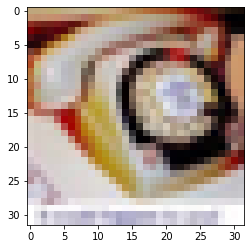

In [19]:
showimg(x_train,y_train,5)

In [20]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [21]:
# Normalize the Dataset
x_train /= 255
x_test /= 255

aquarium_fish


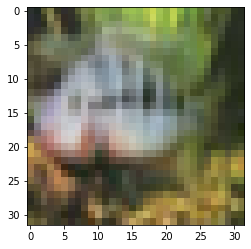

In [22]:
showimg(x_train,y_train,4)

In [23]:
IMG_SIZE = 32
INIT_LR = 1e-5
EPOCHS =  200
BS = 32
NUM_CLASSES = 100

In [24]:
# Convert class vectors to binary class matrices.
y_train = np_utils.to_categorical(y_train,NUM_CLASSES)
y_test = np_utils.to_categorical(y_test,NUM_CLASSES)

In [25]:
y_train.shape

(50000, 100)

In [26]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)

In [27]:
datagen.fit(x_train)

In [28]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(NUM_CLASSES, activation='softmax'))
#sgd = SGD(lr=INIT_LR,momentum=0.9,nesterov=False)
model.compile(loss="categorical_crossentropy", optimizer='sgd',metrics=["accuracy"])

verbose=0 will show you nothing (silent)

verbose=1 will show you an animated progress bar like this:

==================================================

verbose=2 will just mention the number of epoch like this:
1/100


In [29]:
H  = model.fit_generator(datagen.flow(x_train, y_train,batch_size=BS),
                        epochs = EPOCHS,
                        steps_per_epoch=x_train.shape[0] // BS,
                        validation_data=(x_test, y_test))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
1562/1562 [==============================] - 49s 19ms/step - loss: 4.6060 - accuracy: 0.0105 - val_loss: 4.6040 - val_accuracy: 0.0138
Epoch 2/200
1562/1562 [==============================] - 29s 19ms/step - loss: 4.6024 - accuracy: 0.0126 - val_loss: 4.5732 - val_accuracy: 0.0200
Epoch 3/200
1562/1562 [==============================] - 29s 19ms/step - loss: 4.5389 - accuracy: 0.0193 - val_loss: 4.3894 - val_accuracy: 0.0329
Epoch 4/200
1562/1562 [==============================] - 30s 19ms/step - loss: 4.3826 - accuracy: 0.0296 - val_loss: 4.2215 - val_accuracy: 0.0538
Epoch 5/200
1562/1562 [==============================] - 30s 19ms/step - loss: 4.2616 - accuracy: 0.0466 - val_loss: 4.0999 - val_accuracy: 0.0891
Epoch 6/200
1562/1562 [==============================] - 29s 19ms/step - loss: 4.1402 - accuracy: 0.0625 - val_loss: 3.9495 - val_accuracy: 0.0998
Epoch 7/200
1562/1562 [==============================] - 30s 19ms/step - loss: 4.0424 - accuracy: 0.0752 - val_loss: 3

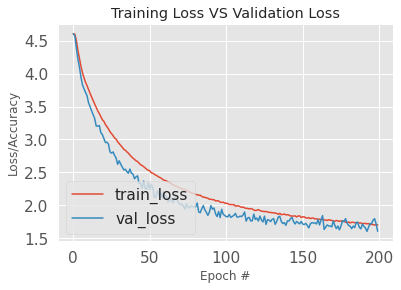

<Figure size 432x288 with 0 Axes>

In [40]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss VS Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig('graph.png')

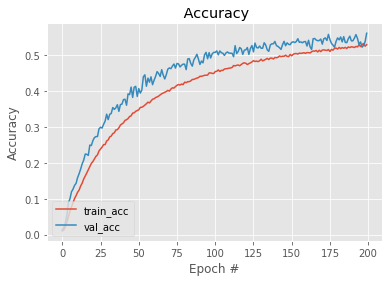

In [31]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title(" Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

In [32]:
x_train.shape

(50000, 32, 32, 3)

In [33]:
x_test.shape

(10000, 32, 32, 3)

Confusion Matrix on Test Set


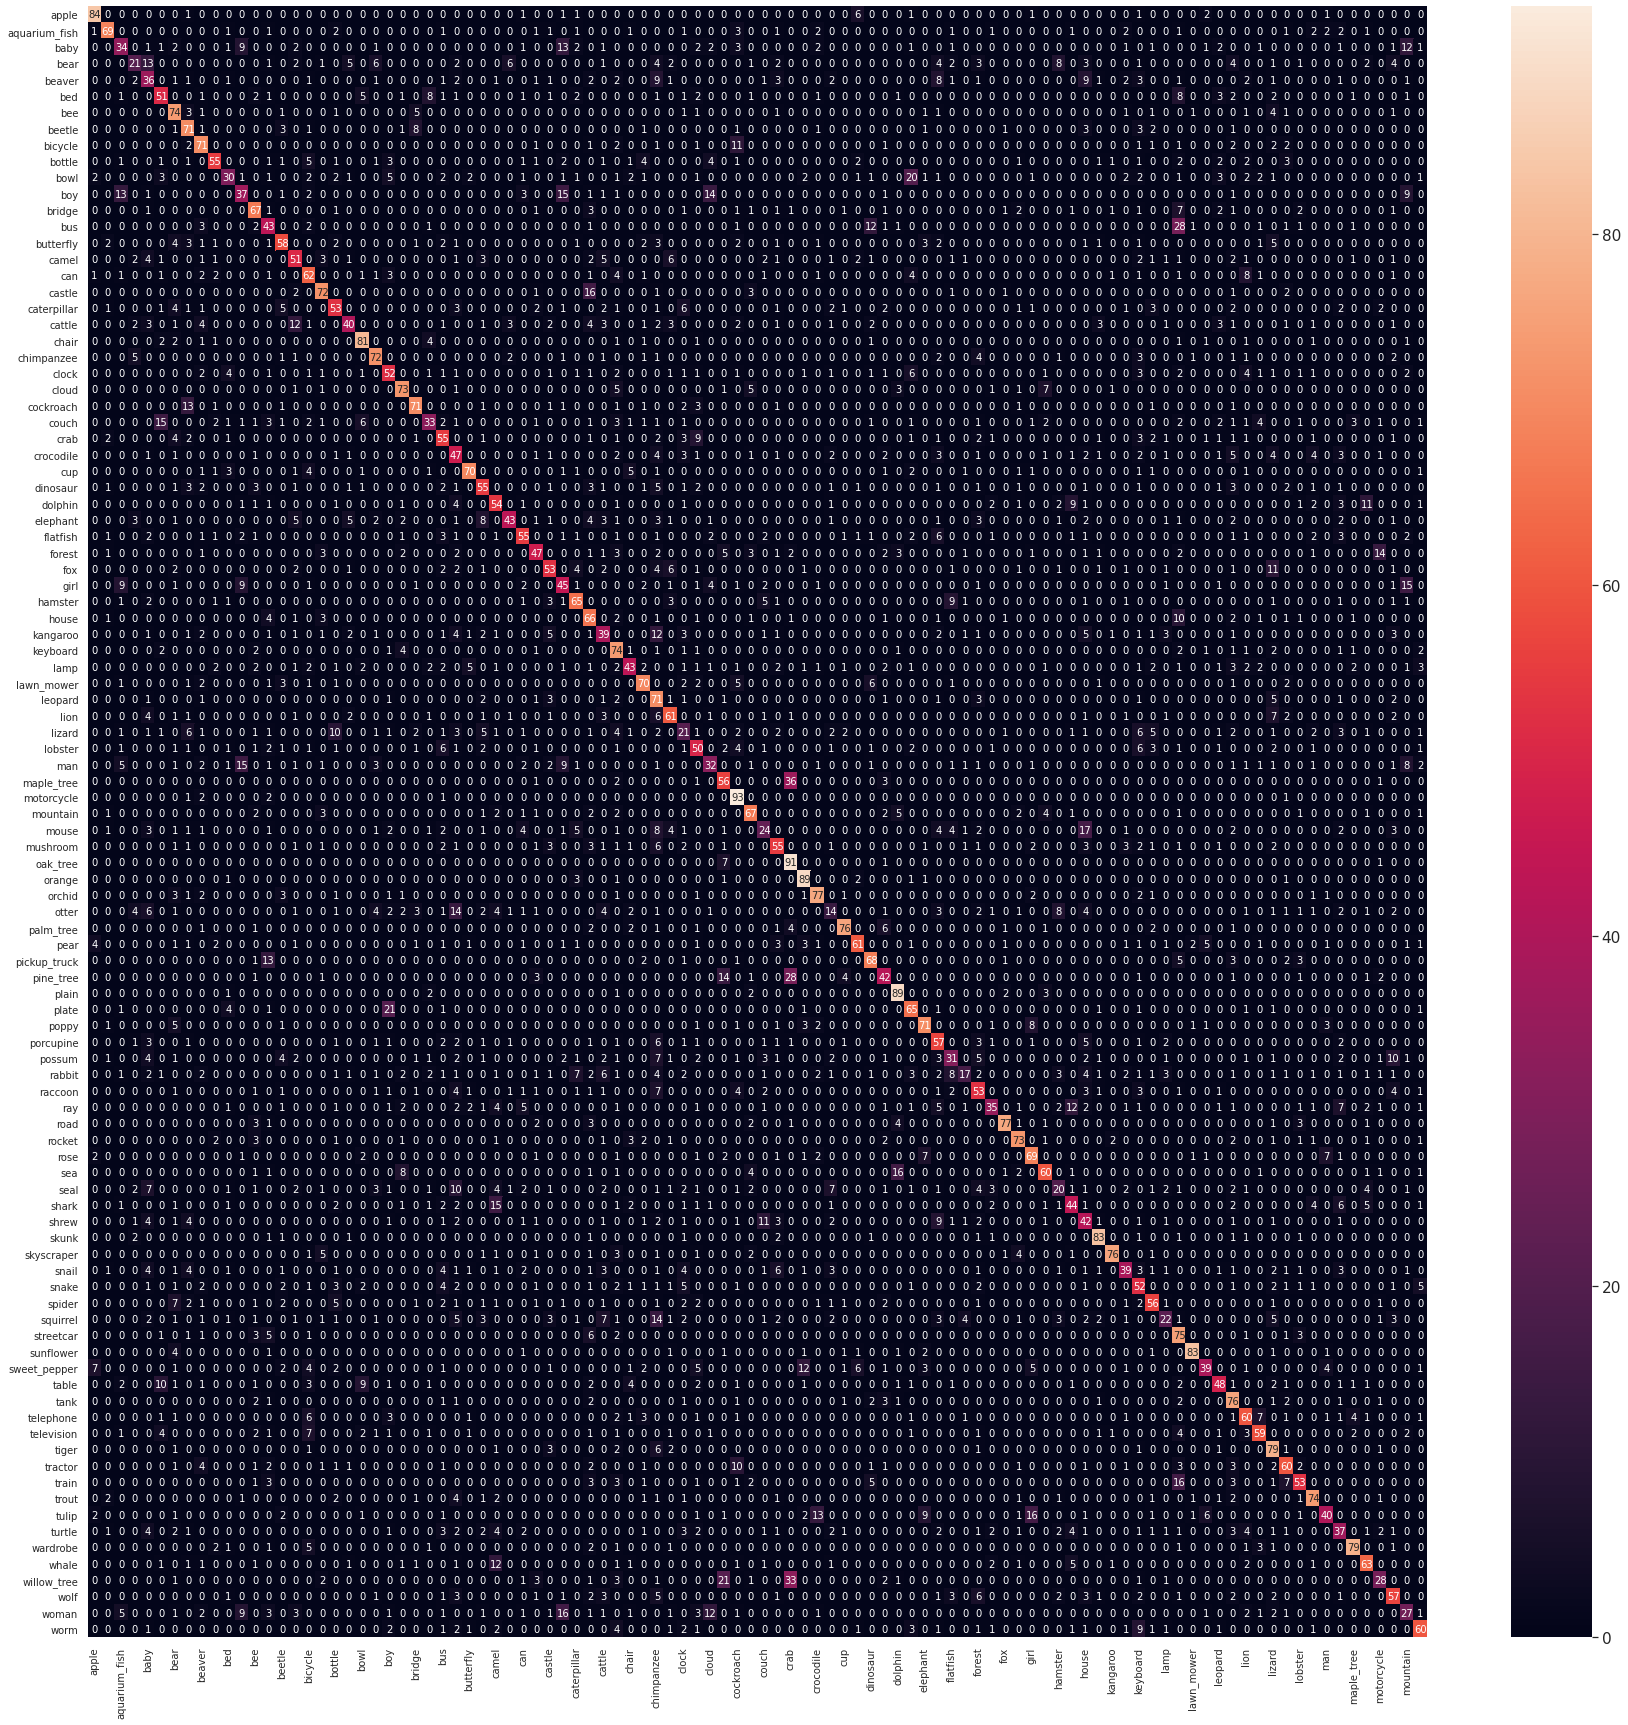

In [34]:
print('Confusion Matrix on Test Set')
pred = model.predict(x=x_test)
pred = np.argmax(pred, axis=1)
temp = np.argmax(y_test,axis=1)
cm = confusion_matrix(temp, pred)
df_cm = pd.DataFrame(cm, range(NUM_CLASSES), range(NUM_CLASSES))
plt.figure(figsize=(30,30))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
ax.set_xticklabels(label_names, rotation='vertical', fontsize=10)
ax.set_yticklabels(label_names, rotation='horizontal', fontsize=10)
plt.show()

In [35]:
def predimageTest(path,y):
    plt.imshow(path)
    test = img_to_array(path)
    test = np.expand_dims(test,axis=0) 
    result = model.predict(test,batch_size = BS)
    y_class = result.argmax(axis=1)
    result = (result*100)
    result = list(np.around(np.array(result),1))
    i = y_class[0]
    s = result[0][i]
    plt.text(0, 40,y[i],size=30,color='red')
    plt.text(20, 40,s,size=25,color='green')
    print(result)
    print(y[i])

[array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0.3,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0.2,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. , 98.5,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  0. ,  0. ,  0. ,
        0. ], dtype=float32)]
sea


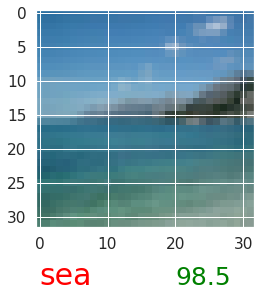

In [36]:
predimageTest(x_test[56],label_names)


[array([ 0. ,  1.3,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  0. ,  0.1,  0.4,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  3.7,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. , 92.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  1.7,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ], dtype=float32)]
rose


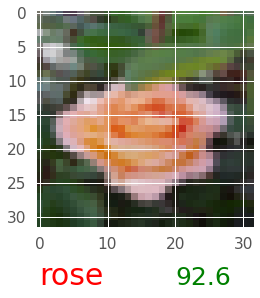

In [41]:
predimageTest(x_test[128],label_names)


In [38]:
def predimage(path,y):
    from PIL import Image,ImageDraw
    image = Image.open(path)
    test = load_img(path,target_size=(IMG_SIZE,IMG_SIZE))
    test = img_to_array(test)
    test = np.expand_dims(test,axis=0)
    test /= 255 
    result = model.predict(test,batch_size = BS)
    y_class = result.argmax(axis=1)
    result = (result*100)
    result = list(np.around(np.array(result),1))
    i = y_class[0]
    s = result[0][i]
    plt.text(1, 1,y[i],size=30,color='red', horizontalalignment='left',verticalalignment='top')
    plt.text(0.5, 0.5,s,size=25,color='green',horizontalalignment='right',verticalalignment='bottom')
    plt.imshow(image)
    print(result)
    print(y[i])

[array([ 0. ,  0. ,  0.1,  0. ,  0. ,  0. ,  0.8,  0.4,  1.5,  0. ,  0. ,
        0. ,  0.1,  0. ,  0. , 60. ,  0. ,  0.9,  0.1,  0.6,  0. ,  0. ,
        0.1,  0. ,  0.5,  0. ,  0.6,  0.7,  0. ,  7.2,  0. ,  0.5,  0. ,
        0. ,  0.3,  0. ,  0. ,  0.2,  1.4,  0. ,  0.3,  0. ,  0.3,  0.3,
        3.3,  0.8,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0.1,  0.1,  0. ,  0. ,  0.1,  0.7,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0.4,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0.1,  0.2, 10.8,  0. ,  0. ,  0. ,  0. ,  0.1,  2.1,  0. ,  0. ,
        0. ,  3.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ], dtype=float32)]
camel


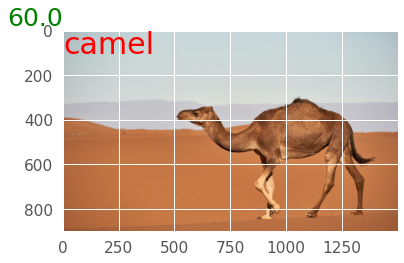

In [55]:
predimage('/content/cam.jpg',label_names)


[array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0.7,  0. ,  0. ,  0. ,  0.4,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.2,  0. ,  0. , 92.3,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0.8,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        5.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ], dtype=float32)]
leopard


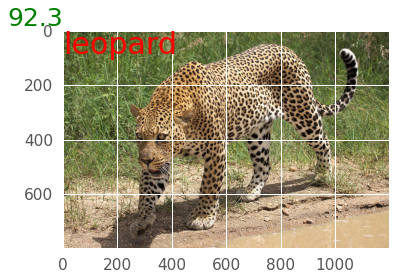

In [57]:
predimage('/content/leop.jpg',label_names)